<a href="https://colab.research.google.com/github/pedroafleite/crypto-risk-assessment/blob/main/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install quandl

In [2]:
import quandl as qd
import pandas as pd
import numpy as np
import datetime
import fbprophet
import matplotlib.pyplot as plt


import plotly.offline as py
import plotly.graph_objs as go
import warnings
warnings.simplefilter("ignore")
py.init_notebook_mode()

In [3]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

# **Bitcoin**

In [4]:
KEY = ""
qd.ApiConfig.api_key = KEY
bitcoin = qd.get("BCHAIN/MKPRU")
bitcoin = bitcoin.loc[(bitcoin !=0).any(1)]

In [5]:
bitcoin = bitcoin.reset_index()
bitcoin.head()

,Date,Value
0,2010-08-16,0.0769
1,2010-08-18,0.0688
2,2010-08-19,0.0667
3,2010-08-20,0.0700
4,2010-08-21,0.0664


In [6]:
bitcoin["log_y"] = np.log(bitcoin["Value"])

In [7]:
bitcoin = bitcoin.rename(columns={"Date": "ds", "log_y" : "y"})
bitcoin.head()

,ds,Value,y
0,2010-08-16,0.0769,-2.565249
1,2010-08-18,0.0688,-2.676552
2,2010-08-19,0.0667,-2.707550
3,2010-08-20,0.0700,-2.659260
4,2010-08-21,0.0664,-2.712058


In [8]:
priors = [0.005, 0.05]
prophets, labels = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior, daily_seasonality=True)
    prophet.fit(bitcoin)
 
    prophets.append(prophet)
    labels.append(r"CP Prior = " + str(prior))

In [9]:
forecasts = []
for prophet in prophets:
    forecast = prophet.make_future_dataframe(periods=365 * 2, freq="D")
    forecast = prophet.predict(forecast)
 
    forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
    forecasts.append(forecast)

In [10]:
output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = "0.005_ds", right_on = "0.05_ds")
output = output.rename(columns={"0.005_ds": "Date"}).drop("0.05_ds", axis=1)

In [11]:
output = output.set_index('Date')
output.head()

,trend_x,yhat_lower_x,yhat_upper_x,trend_lower_x,trend_upper_x,additive_terms_x,additive_terms_lower_x,additive_terms_upper_x,daily_x,daily_lower_x,daily_upper_x,weekly_x,weekly_lower_x,weekly_upper_x,yearly_x,yearly_lower_x,yearly_upper_x,multiplicative_terms_x,multiplicative_terms_lower_x,multiplicative_terms_upper_x,yhat_x,trend_y,yhat_lower_y,yhat_upper_y,trend_lower_y,trend_upper_y,additive_terms_y,additive_terms_lower_y,additive_terms_upper_y,daily_y,daily_lower_y,daily_upper_y,weekly_y,weekly_lower_y,weekly_upper_y,yearly_y,yearly_lower_y,yearly_upper_y,multiplicative_terms_y,multiplicative_terms_lower_y,multiplicative_terms_upper_y,yhat_y
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-08-16,-2.298604,-1.977052,-0.286151,-2.298604,-2.298604,1.143531,1.143531,1.143531,1.063183,1.063183,1.063183,-0.001925,-0.001925,-0.001925,0.082273,0.082273,0.082273,0.0,0.0,0.0,-1.155073,-2.660491,-3.475458,-2.588301,-2.660491,-2.660491,-0.354040,-0.354040,-0.354040,-0.444503,-0.444503,-0.444503,-0.000260,-0.000260,-0.000260,0.090723,0.090723,0.090723,0.0,0.0,0.0,-3.014530
2010-08-18,-2.287427,-2.022897,-0.358001,-2.287427,-2.287427,1.121689,1.121689,1.121689,1.063183,1.063183,1.063183,-0.001271,-0.001271,-0.001271,0.059777,0.059777,0.059777,0.0,0.0,0.0,-1.165738,-2.627334,-3.435276,-2.533875,-2.627334,-2.627334,-0.359435,-0.359435,-0.359435,-0.444503,-0.444503,-0.444503,-0.000099,-0.000099,-0.000099,0.085167,0.085167,0.085167,0.0,0.0,0.0,-2.986769
2010-08-19,-2.281839,-2.002202,-0.307243,-2.281839,-2.281839,1.113072,1.113072,1.113072,1.063183,1.063183,1.063183,0.001486,0.001486,0.001486,0.048403,0.048403,0.048403,0.0,0.0,0.0,-1.168767,-2.610756,-3.412377,-2.505171,-2.610756,-2.610756,-0.360433,-0.360433,-0.360433,-0.444503,-0.444503,-0.444503,0.002119,0.002119,0.002119,0.081950,0.081950,0.081950,0.0,0.0,0.0,-2.971189
2010-08-20,-2.276251,-2.046512,-0.339093,-2.276251,-2.276251,1.099334,1.099334,1.099334,1.063183,1.063183,1.063183,-0.000924,-0.000924,-0.000924,0.037074,0.037074,0.037074,0.0,0.0,0.0,-1.176917,-2.594178,-3.381748,-2.540609,-2.594178,-2.594178,-0.366911,-0.366911,-0.366911,-0.444503,-0.444503,-0.444503,-0.000845,-0.000845,-0.000845,0.078437,0.078437,0.078437,0.0,0.0,0.0,-2.961088
2010-08-21,-2.270663,-2.020107,-0.372681,-2.270663,-2.270663,1.088506,1.088506,1.088506,1.063183,1.063183,1.063183,-0.000562,-0.000562,-0.000562,0.025885,0.025885,0.025885,0.0,0.0,0.0,-1.182157,-2.577599,-3.401357,-2.511669,-2.577599,-2.577599,-0.370913,-0.370913,-0.370913,-0.444503,-0.444503,-0.444503,-0.001038,-0.001038,-0.001038,0.074628,0.074628,0.074628,0.0,0.0,0.0,-2.948512


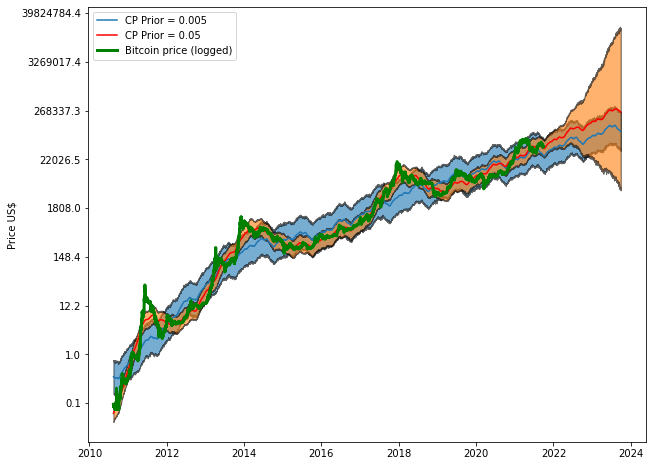

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output.index, output["yhat_x"], label=labels[0])
ax.fill_between(output.index, output["yhat_upper_x"], output["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(output.index, output["yhat_y"], "r", label=labels[1]);
ax.fill_between(output.index, output["yhat_upper_y"], output["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(bitcoin.ds, bitcoin.y, color="green", linewidth=3, label=r"Bitcoin price (logged)")
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price US$")
plt.show()

In [13]:
output = output.reset_index()
output = output.rename(columns={"Date": "ds", "log_y" : "y"})
btc_prophet = pd.merge(bitcoin, output, how='inner', on='ds', sort=True)
btc_prophet.head()

,ds,Value,y,trend_x,yhat_lower_x,yhat_upper_x,trend_lower_x,trend_upper_x,additive_terms_x,additive_terms_lower_x,additive_terms_upper_x,daily_x,daily_lower_x,daily_upper_x,weekly_x,weekly_lower_x,weekly_upper_x,yearly_x,yearly_lower_x,yearly_upper_x,multiplicative_terms_x,multiplicative_terms_lower_x,multiplicative_terms_upper_x,yhat_x,trend_y,yhat_lower_y,yhat_upper_y,trend_lower_y,trend_upper_y,additive_terms_y,additive_terms_lower_y,additive_terms_upper_y,daily_y,daily_lower_y,daily_upper_y,weekly_y,weekly_lower_y,weekly_upper_y,yearly_y,yearly_lower_y,yearly_upper_y,multiplicative_terms_y,multiplicative_terms_lower_y,multiplicative_terms_upper_y,yhat_y
0,2010-08-16,0.0769,-2.565249,-2.298604,-1.977052,-0.286151,-2.298604,-2.298604,1.143531,1.143531,1.143531,1.063183,1.063183,1.063183,-0.001925,-0.001925,-0.001925,0.082273,0.082273,0.082273,0.0,0.0,0.0,-1.155073,-2.660491,-3.475458,-2.588301,-2.660491,-2.660491,-0.354040,-0.354040,-0.354040,-0.444503,-0.444503,-0.444503,-0.000260,-0.000260,-0.000260,0.090723,0.090723,0.090723,0.0,0.0,0.0,-3.014530
1,2010-08-18,0.0688,-2.676552,-2.287427,-2.022897,-0.358001,-2.287427,-2.287427,1.121689,1.121689,1.121689,1.063183,1.063183,1.063183,-0.001271,-0.001271,-0.001271,0.059777,0.059777,0.059777,0.0,0.0,0.0,-1.165738,-2.627334,-3.435276,-2.533875,-2.627334,-2.627334,-0.359435,-0.359435,-0.359435,-0.444503,-0.444503,-0.444503,-0.000099,-0.000099,-0.000099,0.085167,0.085167,0.085167,0.0,0.0,0.0,-2.986769
2,2010-08-19,0.0667,-2.707550,-2.281839,-2.002202,-0.307243,-2.281839,-2.281839,1.113072,1.113072,1.113072,1.063183,1.063183,1.063183,0.001486,0.001486,0.001486,0.048403,0.048403,0.048403,0.0,0.0,0.0,-1.168767,-2.610756,-3.412377,-2.505171,-2.610756,-2.610756,-0.360433,-0.360433,-0.360433,-0.444503,-0.444503,-0.444503,0.002119,0.002119,0.002119,0.081950,0.081950,0.081950,0.0,0.0,0.0,-2.971189
3,2010-08-20,0.0700,-2.659260,-2.276251,-2.046512,-0.339093,-2.276251,-2.276251,1.099334,1.099334,1.099334,1.063183,1.063183,1.063183,-0.000924,-0.000924,-0.000924,0.037074,0.037074,0.037074,0.0,0.0,0.0,-1.176917,-2.594178,-3.381748,-2.540609,-2.594178,-2.594178,-0.366911,-0.366911,-0.366911,-0.444503,-0.444503,-0.444503,-0.000845,-0.000845,-0.000845,0.078437,0.078437,0.078437,0.0,0.0,0.0,-2.961088
4,2010-08-21,0.0664,-2.712058,-2.270663,-2.020107,-0.372681,-2.270663,-2.270663,1.088506,1.088506,1.088506,1.063183,1.063183,1.063183,-0.000562,-0.000562,-0.000562,0.025885,0.025885,0.025885,0.0,0.0,0.0,-1.182157,-2.577599,-3.401357,-2.511669,-2.577599,-2.577599,-0.370913,-0.370913,-0.370913,-0.444503,-0.444503,-0.444503,-0.001038,-0.001038,-0.001038,0.074628,0.074628,0.074628,0.0,0.0,0.0,-2.948512


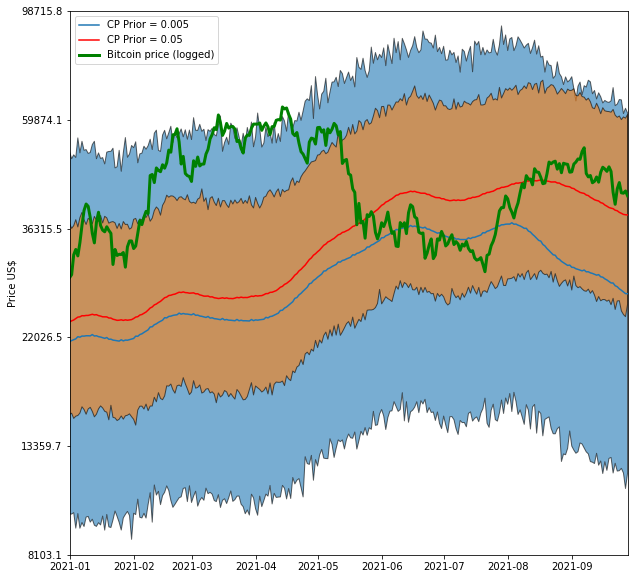

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(btc_prophet.ds, btc_prophet["yhat_x"], label=labels[0])
ax.fill_between(btc_prophet.ds, btc_prophet["yhat_upper_x"], btc_prophet["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(btc_prophet.ds, btc_prophet["yhat_y"], "r", label=labels[1]);
ax.fill_between(btc_prophet.ds, btc_prophet["yhat_upper_y"], btc_prophet["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(btc_prophet.ds, btc_prophet.y, color="green", linewidth=3, label=r"Bitcoin price (logged)")
ax.set_ylim([9,11.5])
ax.plot(ylim=(15000,160000))
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
ax.set_xlim([datetime.date(2021, 1, 1), datetime.datetime.today().date()])
plt.legend(loc="upper left")
plt.ylabel(r"Price US$")
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error

MAE: 1.086


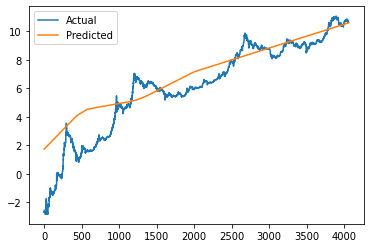

In [16]:
# calculate MAE between expected and predicted values for June
y_true = bitcoin['y'].values
y_pred = output['trend_x'][-bitcoin['y'].shape[0]:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

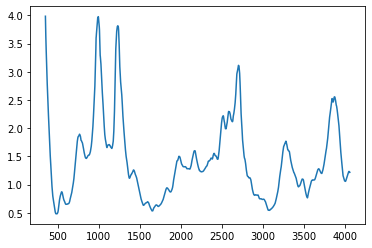

In [17]:
bitcoin['50SMA'] = bitcoin.Value.rolling(window=50).mean()
bitcoin['350SMA'] = bitcoin.Value.rolling(window=350).mean()
bitcoin['R'] = bitcoin['50SMA']/bitcoin['350SMA']
bitcoin = bitcoin.dropna()

bitcoin['R'].plot();

# **Ethereum**

In [18]:
KEY = ""
qd.ApiConfig.api_key = KEY
eth = qd.get("BITFINEX/ETHUSD")
eth = eth.loc[(eth !=0).any(1)]

In [19]:
eth = eth.reset_index()
eth.head()

,Date,High,Low,Mid,Last,Bid,Ask,Volume
0,2016-03-14,14.950,11.400,12.9325,12.925,12.925,12.940,22922.937642
1,2016-03-15,13.421,11.607,12.9665,12.765,12.924,13.009,18157.378517
2,2016-03-16,13.890,12.621,12.8200,12.800,12.800,12.840,5431.139409
3,2016-03-17,12.893,10.436,11.2450,11.368,11.172,11.318,25158.103084
4,2016-03-18,11.200,8.338,10.8155,10.750,10.751,10.880,46391.436185


In [20]:
eth["log_y"] = np.log(eth["Last"])
eth = eth.rename(columns={"Date": "ds", "log_y" : "y"})
eth.head()

,ds,High,Low,Mid,Last,Bid,Ask,Volume,y
0,2016-03-14,14.950,11.400,12.9325,12.925,12.925,12.940,22922.937642,2.559163
1,2016-03-15,13.421,11.607,12.9665,12.765,12.924,13.009,18157.378517,2.546707
2,2016-03-16,13.890,12.621,12.8200,12.800,12.800,12.840,5431.139409,2.549445
3,2016-03-17,12.893,10.436,11.2450,11.368,11.172,11.318,25158.103084,2.430802
4,2016-03-18,11.200,8.338,10.8155,10.750,10.751,10.880,46391.436185,2.374906


In [21]:
priors = [0.0005, 0.005]
prophets, labels = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(eth)
 
    prophets.append(prophet)
    labels.append(r"CP Prior = " + str(prior))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
forecasts = []
for prophet in prophets:
    forecast = prophet.make_future_dataframe(periods=365 * 2, freq="D")
    forecast = prophet.predict(forecast)
 
    forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
    forecasts.append(forecast)

In [23]:
output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = "0.0005_ds", right_on = "0.005_ds")
output = output.rename(columns={"0.0005_ds": "Date"}).drop("0.005_ds", axis=1)
output = output.set_index('Date')

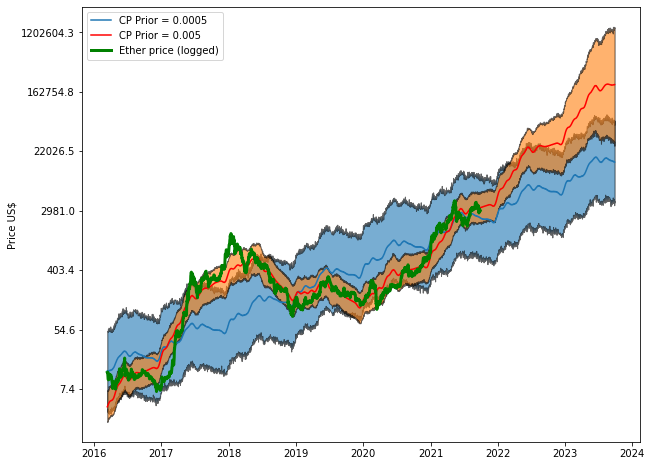

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output.index, output["yhat_x"], label=labels[0])
ax.fill_between(output.index, output["yhat_upper_x"], output["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(output.index, output["yhat_y"], "r", label=labels[1]);
ax.fill_between(output.index, output["yhat_upper_y"], output["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(eth.ds, eth.y, color="green", linewidth=3, label=r"Ether price (logged)")
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price US$")
plt.show()

MAE: 1.919


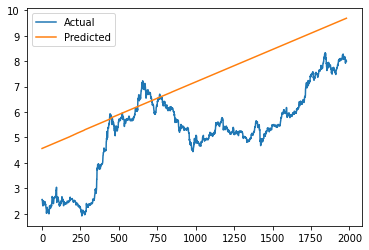

In [25]:
# calculate MAE between expected and predicted values for June
y_true = eth['y'].values
y_pred = output['trend_x'][-eth['y'].shape[0]:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [26]:
output['trend_x'][-(eth['y'].shape[0]):].values

array([4.56820326, 4.57075515, 4.57330703, ..., 9.68473461, 9.68728649,
       9.68983838])

In [27]:
output['trend_x'].values

array([2.66430711, 2.66685972, 2.66941233, ..., 9.68473461, 9.68728649,
       9.68983838])

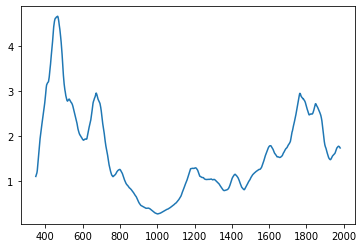

In [28]:
eth['50SMA'] = eth.Last.rolling(window=50).mean()
eth['350SMA'] = eth.Last.rolling(window=350).mean()
eth['R'] = eth['50SMA']/eth['350SMA']
eth = eth.dropna()

eth['R'].plot();

# **ETH/BTC**

In [29]:
KEY = "zykxDXyzgxQSoKZM6y6v"
qd.ApiConfig.api_key = KEY
ethbtc = qd.get("BITFINEX/ETHBTC")
ethbtc = ethbtc.loc[(ethbtc !=0).any(1)]

In [30]:
ethbtc = ethbtc.reset_index()
ethbtc.head()

,Date,High,Low,Mid,Last,Bid,Ask,Volume
0,2016-03-14,0.050580,0.028241,0.031181,0.031103,0.031102,0.031260,111142.045174
1,2016-03-15,0.032004,0.027950,0.031298,0.031399,0.031207,0.031390,62965.262239
2,2016-03-16,0.033500,0.030465,0.030700,0.030690,0.030690,0.030709,55947.825399
3,2016-03-17,0.030989,0.024759,0.026878,0.026816,0.026821,0.026935,94445.983815
4,2016-03-18,0.026960,0.020150,0.026555,0.026509,0.026506,0.026605,141106.891752


In [31]:
ethbtc["log_y"] = np.log(ethbtc["Last"])
ethbtc = ethbtc.rename(columns={"Date": "ds", "log_y" : "y"})
ethbtc.head()

,ds,High,Low,Mid,Last,Bid,Ask,Volume,y
0,2016-03-14,0.050580,0.028241,0.031181,0.031103,0.031102,0.031260,111142.045174,-3.470451
1,2016-03-15,0.032004,0.027950,0.031298,0.031399,0.031207,0.031390,62965.262239,-3.460979
2,2016-03-16,0.033500,0.030465,0.030700,0.030690,0.030690,0.030709,55947.825399,-3.483818
3,2016-03-17,0.030989,0.024759,0.026878,0.026816,0.026821,0.026935,94445.983815,-3.618757
4,2016-03-18,0.026960,0.020150,0.026555,0.026509,0.026506,0.026605,141106.891752,-3.630271


In [32]:
priors = [0.0015, 0.015]
prophets, labels = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(ethbtc)
 
    prophets.append(prophet)
    labels.append(r"CP Prior = " + str(prior))

forecasts = []
for prophet in prophets:
    forecast = prophet.make_future_dataframe(periods=365 * 2, freq="D")
    forecast = prophet.predict(forecast)
 
    forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
    forecasts.append(forecast)

output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = "0.0015_ds", right_on = "0.015_ds")
output = output.rename(columns={"0.0015_ds": "Date"}).drop("0.015_ds", axis=1)
output = output.set_index('Date')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


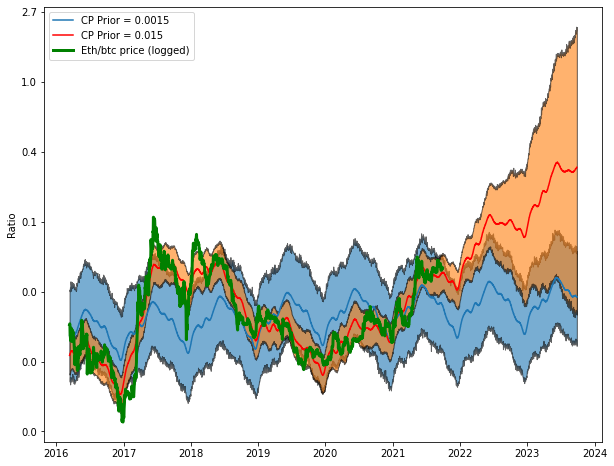

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output.index, output["yhat_x"], label=labels[0])
ax.fill_between(output.index, output["yhat_upper_x"], output["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(output.index, output["yhat_y"], "r", label=labels[1]);
ax.fill_between(output.index, output["yhat_upper_y"], output["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(ethbtc.ds, ethbtc.y, color="green", linewidth=3, label=r"Eth/btc price (logged)")
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Ratio")
plt.show()

MAE: 0.498


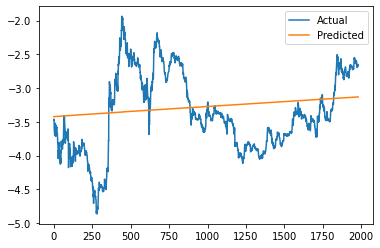

In [34]:
# calculate MAE between expected and predicted values for June
y_true = ethbtc['y'].values
y_pred = output['trend_x'][-ethbtc['y'].shape[0]:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

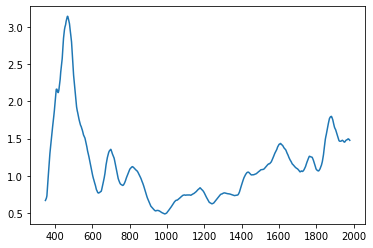

In [35]:
ethbtc['50SMA'] = ethbtc.Last.rolling(window=50).mean()
ethbtc['350SMA'] = ethbtc.Last.rolling(window=350).mean()
ethbtc['R'] = ethbtc['50SMA']/ethbtc['350SMA']
ethbtc = ethbtc.dropna()

ethbtc['R'].plot();